In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe

import fredapi as fa
from local_settings import fred as settings
fred = fa.Fred(settings['api_key'])

ModuleNotFoundError: No module named 'seaborn'

In [28]:
tickers = []

with open('tickers.txt') as f:
    for line in f:
        tickers.append(line.strip())

In [57]:
assets = {}

for ticker in tickers:
    assets[ticker] = fred.get_series(ticker).loc['2020-06-01':'2023-10-01']

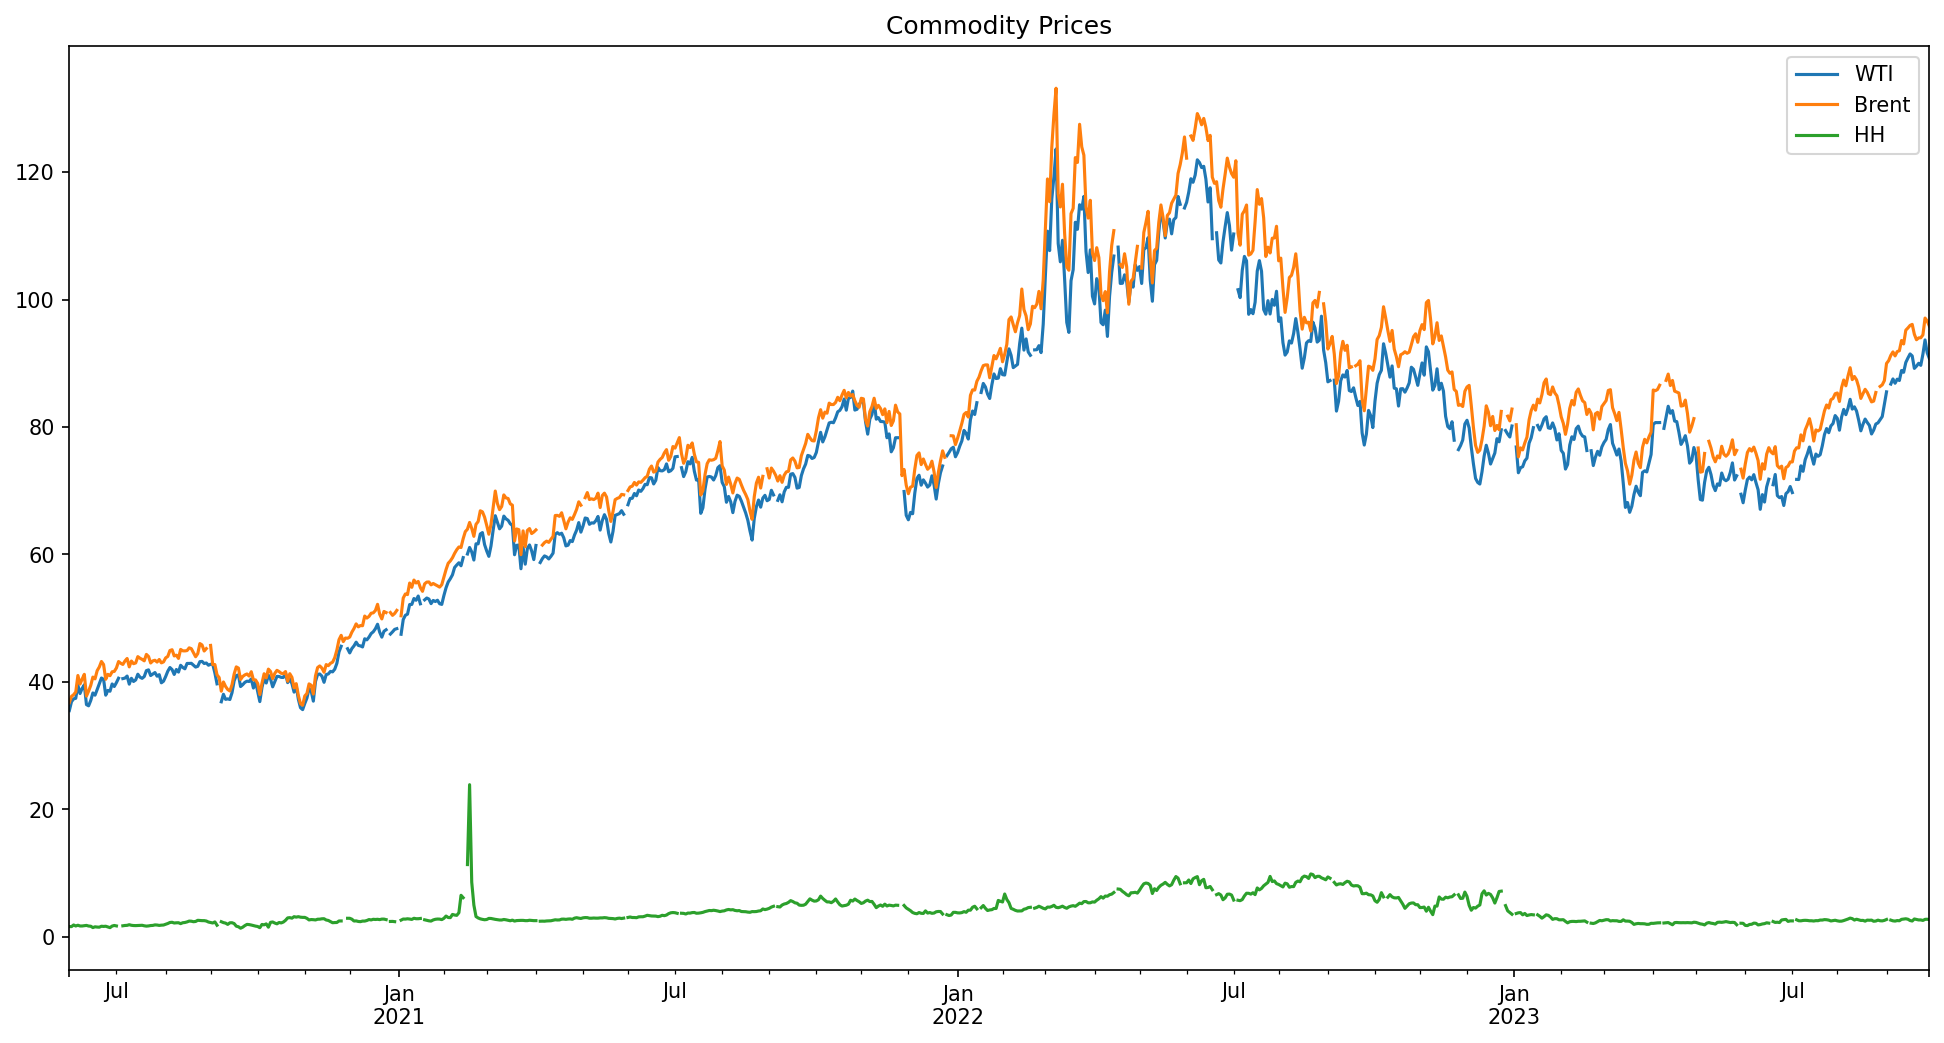

In [58]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['DCOILWTICO'].plot(label='WTI')
assets['DCOILBRENTEU'].plot(label='Brent')
assets['DHHNGSP'].plot(label='HH')
#assets['PNGASEUUSDM'].plot(label='TTF')

plt.title('Commodity Prices')
plt.legend()

In [60]:
returns = pd.DataFrame.from_dict(assets).fillna(method='ffill')

for ticker in tickers:
    returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

,DCOILWTICO,DCOILBRENTEU,DHHNGSP,Ret_DCOILWTICO,Ret_DCOILBRENTEU,Ret_DHHNGSP
2020-06-02,36.88,37.72,1.58,0.038418,0.026324,-0.006309
2020-06-03,37.33,37.98,1.84,0.012128,0.006869,0.152341
2020-06-04,37.42,38.41,1.68,0.002408,0.011258,-0.090972
2020-06-05,39.49,41.00,1.80,0.053842,0.065254,0.068993
2020-06-08,38.17,39.66,1.68,-0.033998,-0.033229,-0.068993


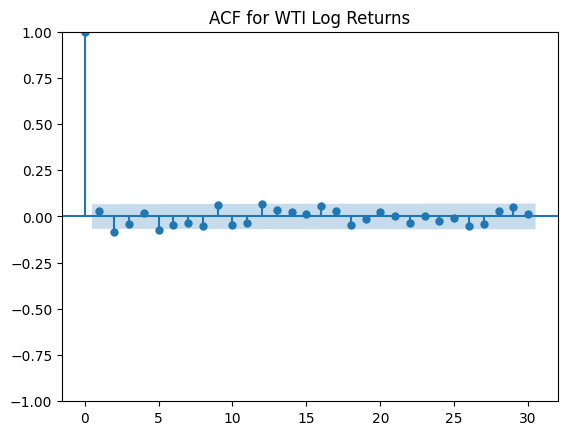

In [71]:
series_wti = returns['Ret_DCOILWTICO']

acf_ret_wti = acf(series_wti)
plot_acf(series_wti, lags=30, title='ACF for WTI Log Returns')
plt.show()

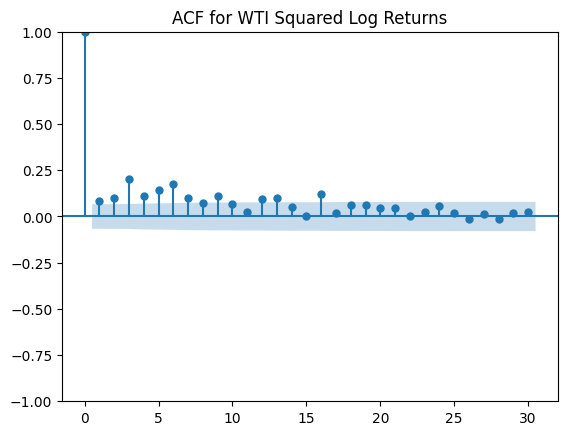

In [72]:
acf_retsq_wti = acf(series_wti**2)
plot_acf(series_wti**2, lags=30, title='ACF for WTI Squared Log Returns')
plt.show()

In [73]:
describe(series_wti)

,Ret_DCOILWTICO
nobs,8.690000e+02
missing,0.000000e+00
mean,1.080642e-03
std_err,8.235387e-04
upper_ci,2.694748e-03
lower_ci,-5.334643e-04
std,2.427694e-02
iqr,2.791480e-02
iqr_normal,2.069327e-02
mad,1.793358e-02


In [ ]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(series_wti), bw=0.5)